In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
import sklearn
import numpy as np
import pandas as pd

print(sklearn.__version__)
print(np.__version__)
print(pd.__version__)

1.5.0
1.26.4
2.2.2


In [3]:
# Load the cleaned data
SCRAPED_DATA_2023 = "../scrape/nba_games_2023.csv"
data = pd.read_csv(SCRAPED_DATA_2023)

In [4]:
# Create new features for spread (target)
data['spread'] = data["total"] - data["total_opp"]

In [5]:
# Display the structure of the data
print(data.info())

data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18460 entries, 0 to 18459
Columns: 152 entries, Unnamed: 0 to spread
dtypes: bool(1), float64(140), int64(8), object(3)
memory usage: 21.3+ MB
None


,Unnamed: 0,mp,mp.1,fg,fga,fg%,3p,3pa,3p%,ft,...,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won,spread
0,0,240.0,240.0,38.0,72.0,0.528,16.0,37.0,0.432,18.0,...,26.8,155.0,123.0,MIA,107,1,2023,2022-11-07,True,3
1,1,240.0,240.0,40.0,84.0,0.476,14.0,39.0,0.359,13.0,...,37.3,160.0,121.0,POR,110,0,2023,2022-11-07,False,-3
2,2,240.0,240.0,41.0,78.0,0.526,8.0,24.0,0.333,15.0,...,41.1,250.0,125.0,DAL,90,1,2023,2022-12-14,True,15
3,3,240.0,240.0,29.0,74.0,0.392,13.0,38.0,0.342,19.0,...,33.0,183.0,110.0,CLE,105,0,2023,2022-12-14,False,-15
4,4,240.0,240.0,39.0,81.0,0.481,6.0,20.0,0.300,14.0,...,29.0,178.0,111.0,DAL,95,1,2016,2015-12-09,True,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18455,18455,240.0,240.0,35.0,81.0,0.432,11.0,26.0,0.423,27.0,...,33.7,160.0,118.0,OKC,92,0,2019,2018-10-19,True,16
18456,18456,240.0,240.0,37.0,74.0,0.500,13.0,25.0,0.520,26.0,...,30.0,139.0,129.0,ORL,108,1,2017,2016-12-14,True,5
18457,18457,240.0,240.0,42.0,89.0,0.472,14.0,33.0,0.424,10.0,...,29.9,175.0,126.0,LAC,113,0,2017,2016-12-14,False,-5
18458,18458,240.0,240.0,41.0,85.0,0.482,9.0,26.0,0.346,26.0,...,27.1,150.0,126.0,MIA,106,1,2020,2020-09-19,True,11


# Data Preprocessing

## Data Cleaning: Handle missing values, outliers, and incorrect data

### Handle Null Values

In [6]:
# Calculate the percentage of missing values for each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

# Filter columns with missing values more than a certain threshold (e.g., 0%)
threshold = 0
columns_with_missing = missing_percentage[missing_percentage > threshold]

# Print columns with the percentage of missing values
print("Columns with missing values and their percentage:")
for column, percentage in columns_with_missing.items():
    print(f"{column}: {percentage:.2f}%")

Columns with missing values and their percentage:
+/-: 100.00%
mp_max: 100.00%
mp_max.1: 100.00%
+/-_opp: 100.00%
mp_max_opp: 100.00%
mp_max_opp.1: 100.00%


In [7]:
# Remove the columns containing null values
nulls = pd.isnull(data).sum()
missing_cols = nulls[nulls>0].index
valid_cols = data.columns[~data.columns.isin(missing_cols)]
data = data[valid_cols].copy()

In [8]:
# Check to ensure data has no null values left
nulls = pd.isnull(data).sum()
nulls[nulls > 0]

Series([], dtype: int64)

### Handling Duplicates

In [9]:
duplicates = data.duplicated().sum()
duplicates

0

### Identify Outliers

In [10]:
# Check for outliers in key numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_columns].describe()

,Unnamed: 0,mp,mp.1,fg,fga,fg%,3p,3pa,3p%,ft,...,stl%_max_opp,blk%_max_opp,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,total_opp,home_opp,season,spread
count,18460.00000,18460.000000,18460.000000,18460.000000,18460.000000,18460.000000,18460.000000,18460.000000,18460.000000,18460.000000,...,18460.000000,18460.000000,18460.000000,18460.000000,18460.000000,18460.000000,18460.000000,18460.000000,18460.000000,18460.000000
mean,9229.50000,241.581798,241.581798,40.048700,87.107746,0.460691,11.123023,31.098104,0.356674,17.455309,...,5.935623,9.070731,40.113516,34.856208,178.744529,118.874810,108.675731,0.500000,2019.248104,0.000000
std,5329.08732,6.958552,6.958552,5.225389,7.236176,0.054808,3.977234,7.902932,0.089379,5.954894,...,4.503804,6.877106,21.235209,8.484451,41.005465,11.093298,12.799743,0.500014,2.176906,14.486744
min,0.00000,240.000000,240.000000,19.000000,60.000000,0.269000,0.000000,4.000000,0.000000,1.000000,...,0.000000,0.000000,4.600000,22.100000,89.000000,77.000000,64.000000,0.000000,2016.000000,-73.000000
25%,4614.75000,240.000000,240.000000,36.000000,82.000000,0.422000,8.000000,26.000000,0.296000,13.000000,...,3.800000,5.200000,25.500000,30.000000,148.000000,111.000000,100.000000,0.000000,2017.000000,-9.000000
50%,9229.50000,240.000000,240.000000,40.000000,87.000000,0.460000,11.000000,31.000000,0.355000,17.000000,...,5.000000,7.500000,33.300000,33.000000,168.000000,119.000000,109.000000,0.500000,2019.000000,0.000000
75%,13844.25000,240.000000,240.000000,43.000000,92.000000,0.500000,14.000000,36.000000,0.417000,21.000000,...,6.700000,10.900000,50.000000,37.200000,203.000000,126.000000,117.000000,1.000000,2021.000000,9.000000
max,18459.00000,340.000000,340.000000,63.000000,124.000000,0.687000,29.000000,70.000000,0.842000,44.000000,...,100.000000,100.000000,100.000000,100.000000,300.000000,162.000000,168.000000,1.000000,2023.000000,73.000000


In [11]:
# Inspect Columns
columns = data.columns.tolist()

# Remove non-numeric columns for correlation calculation
numeric_data = data.select_dtypes(include=[np.number])

# Correlation Analysis
# Calculate the correlation matrix with the target variable 'spread'
correlation_matrix = numeric_data.corr()
correlation_with_target = correlation_matrix['spread'].sort_values(ascending=False)

# Variance Analysis
# Calculate variance for each numerical column
variance = numeric_data.var()

# Apply Domain Knowledge to Identify Irrelevant Columns
# This step is more subjective but we'll identify likely candidates based on domain knowledge
potential_irrelevant_columns = ['mp', 'mp_1', 'mp_opp', 'mp_opp_1', 'index_opp']  # Example list, can be extended based on correlation and variance analysis

# Display results
print(f"CORRELATION WITH SPREAD: \n{correlation_with_target} \n\nVARIANCE DATA \n{variance} \n\nPOTENTIAL IRRELEVANT COLS {potential_irrelevant_columns}")

CORRELATION WITH SPREAD: 
spread          1.000000
+/-_max         0.828791
drtg_opp        0.635152
ortg            0.635152
drtg_max_opp    0.613842
                  ...   
ortg_opp       -0.635152
drtg           -0.635152
+/-_max_opp    -0.828791
usg%                 NaN
usg%_opp             NaN
Name: spread, Length: 142, dtype: float64 

VARIANCE DATA 
Unnamed: 0      2.839917e+07
mp              4.842145e+01
mp.1            4.842145e+01
fg              2.730469e+01
fga             5.236225e+01
                    ...     
drtg_max_opp    1.230613e+02
total_opp       1.638334e+02
home_opp        2.500135e-01
season          4.738918e+00
spread          2.098658e+02
Length: 142, dtype: float64 

POTENTIAL IRRELEVANT COLS ['mp', 'mp_1', 'mp_opp', 'mp_opp_1', 'index_opp']


In [12]:
# Standardize column names
data.columns = data.columns.str.lower().str.replace('%', 'pct').str.replace('.', '_')

# Remove irrelevant columns; usgpct had a 0 correlation with the spread as well as 0 variance. Thus is considered not relevant.
irrelevant_columns = ['mp', 'mp_1', 'mp_opp', 'mp_opp_1', 'index_opp', 'usgpct', 'usgpct_opp']

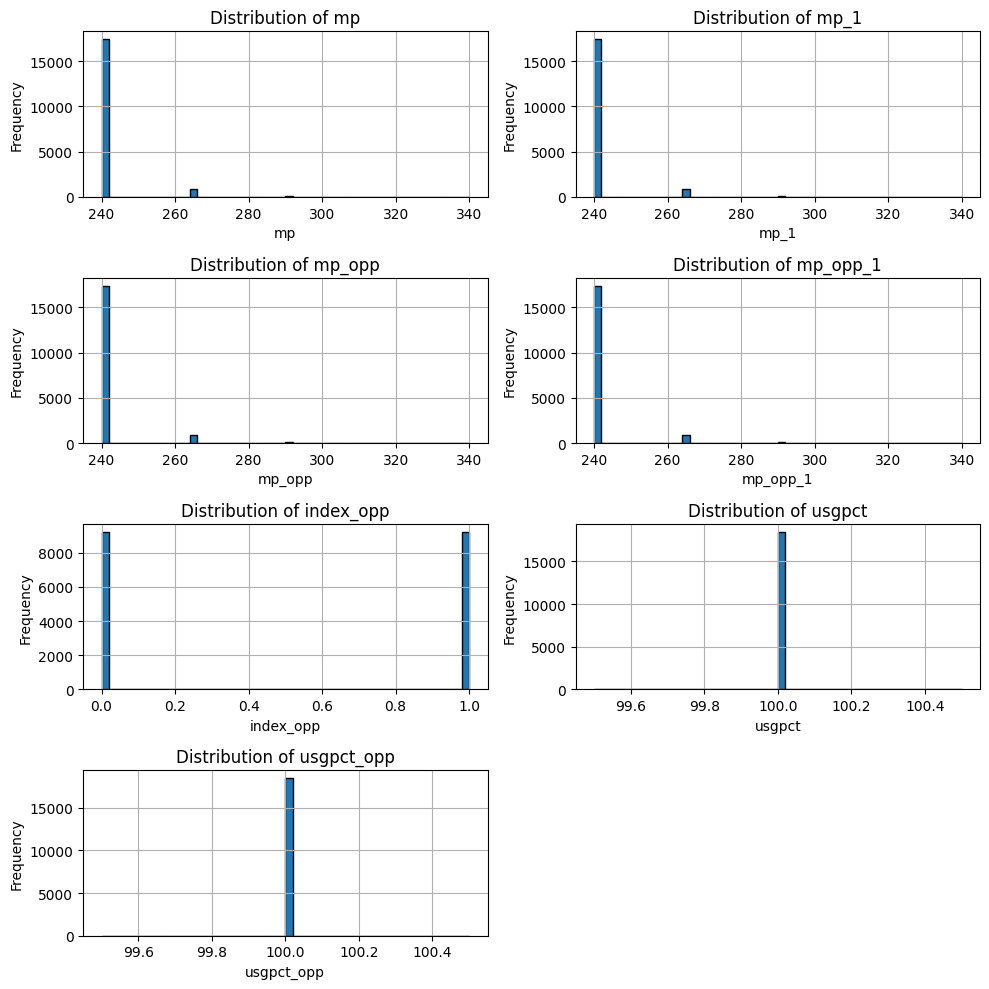

In [13]:
import matplotlib.pyplot as plt
import math

# Number of columns for the layout
n_cols = 2
n_rows = math.ceil(len(irrelevant_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 2.5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plotting histograms for numerical columns to visualize distributions and outliers
for idx, column in enumerate(irrelevant_columns):
    axes[idx].hist(data[column], bins=50, edgecolor='k')
    axes[idx].set_title(f'Distribution of {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True)

# Hide any unused subplots
for i in range(len(irrelevant_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [14]:
# From the above graphs we can see that these cols have 0 distribution and also 0 correlation with our target. Thus we drop
data = data.drop(columns=irrelevant_columns)

## Data Transformation

In [15]:
data.dtypes

unnamed: 0      int64
fg            float64
fga           float64
fgpct         float64
3p            float64
               ...   
home_opp        int64
season          int64
date           object
won              bool
spread          int64
Length: 139, dtype: object

In [16]:
# Identify columns of type object
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns (dtype='object'):", categorical_columns)

Categorical Columns (dtype='object'): ['team', 'team_opp', 'date']


In [17]:
# Exclude columns of type int and float to find potential categorical columns
potential_categorical_columns = data.columns.difference(data.select_dtypes(include=['int64', 'float64']).columns).tolist()
print("Potential Categorical Columns (excluding int and float):", potential_categorical_columns)

Potential Categorical Columns (excluding int and float): ['date', 'team', 'team_opp', 'won']


In [18]:
data[potential_categorical_columns]

,date,team,team_opp,won
0,2022-11-07,POR,MIA,True
1,2022-11-07,MIA,POR,False
2,2022-12-14,CLE,DAL,True
3,2022-12-14,DAL,CLE,False
4,2015-12-09,ATL,DAL,True
...,...,...,...,...
18455,2018-10-19,LAC,OKC,True
18456,2016-12-14,LAC,ORL,True
18457,2016-12-14,ORL,LAC,False
18458,2020-09-19,BOS,MIA,True


In [19]:
# Convert 'date' to datetime
data['date'] = pd.to_datetime(data['date'])

# Convert 'won' from bool to int
data['won'] = data['won'].astype(int)

In [20]:
data[potential_categorical_columns]

,date,team,team_opp,won
0,2022-11-07,POR,MIA,1
1,2022-11-07,MIA,POR,0
2,2022-12-14,CLE,DAL,1
3,2022-12-14,DAL,CLE,0
4,2015-12-09,ATL,DAL,1
...,...,...,...,...
18455,2018-10-19,LAC,OKC,1
18456,2016-12-14,LAC,ORL,1
18457,2016-12-14,ORL,LAC,0
18458,2020-09-19,BOS,MIA,1


In [21]:
# Drop a single column 'Unnamed: 0'
data = data.drop(columns=['unnamed: 0'])

## Feature Engineering

In [22]:
# Adding team avgs for points scored and allowed for each team by season

# Create points scored and allowed columns
data['home_pts_scored'] = data['total']
data['away_pts_scored'] = data['total_opp']
data['home_pts_allowed'] = data['total_opp']
data['away_pts_allowed'] = data['total']

In [23]:
# Calculate average points scored and allowed per game for each team within each season
home_team_averages = data.groupby(['team', 'season']).agg({
    'home_pts_scored': 'mean',
    'home_pts_allowed': 'mean'
}).reset_index()

away_team_averages = data.groupby(['team_opp', 'season']).agg({
    'away_pts_scored': 'mean',
    'away_pts_allowed': 'mean'
}).reset_index()

# Rename columns for clarity
home_team_averages.rename(columns={
    'team': 'home_team',
    'home_pts_scored': 'home_avg_pts_scored',
    'home_pts_allowed': 'home_avg_pts_allowed'
}, inplace=True)

away_team_averages.rename(columns={
    'team_opp': 'away_team',
    'away_pts_scored': 'away_avg_pts_scored',
    'away_pts_allowed': 'away_avg_pts_allowed'
}, inplace=True)

In [24]:
# Merge home team averages
data = data.merge(home_team_averages, how='left', left_on=['team', 'season'], right_on=['home_team', 'season'])

# Merge away team averages
data = data.merge(away_team_averages, how='left', left_on=['team_opp', 'season'], right_on=['away_team', 'season'])

In [25]:
data

,fg,fga,fgpct,3p,3pa,3ppct,ft,fta,ftpct,orb,...,home_pts_scored,away_pts_scored,home_pts_allowed,away_pts_allowed,home_team,home_avg_pts_scored,home_avg_pts_allowed,away_team,away_avg_pts_scored,away_avg_pts_allowed
0,38.0,72.0,0.528,16.0,37.0,0.432,18.0,21.0,0.857,4.0,...,110,107,107,110,POR,112.323529,112.000000,MIA,106.769231,107.153846
1,40.0,84.0,0.476,14.0,39.0,0.359,13.0,15.0,0.867,5.0,...,107,110,110,107,MIA,106.769231,107.153846,POR,112.323529,112.000000
2,41.0,78.0,0.526,8.0,24.0,0.333,15.0,19.0,0.789,5.0,...,105,90,90,105,CLE,111.472222,106.277778,DAL,112.250000,109.972222
3,29.0,74.0,0.392,13.0,38.0,0.342,19.0,26.0,0.731,6.0,...,90,105,105,90,DAL,112.250000,109.972222,CLE,111.472222,106.277778
4,39.0,81.0,0.481,6.0,20.0,0.300,14.0,18.0,0.778,6.0,...,98,95,95,98,ATL,102.543478,99.434783,DAL,101.804598,103.137931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18455,35.0,81.0,0.432,11.0,26.0,0.423,27.0,36.0,0.750,10.0,...,108,92,92,108,LAC,115.113636,114.988636,OKC,113.942529,111.068966
18456,37.0,74.0,0.500,13.0,25.0,0.520,26.0,37.0,0.703,7.0,...,113,108,108,113,LAC,107.883117,103.571429,ORL,100.636364,106.787879
18457,42.0,89.0,0.472,14.0,33.0,0.424,10.0,20.0,0.500,12.0,...,108,113,113,108,ORL,100.636364,106.787879,LAC,107.883117,103.571429
18458,41.0,85.0,0.482,9.0,26.0,0.346,26.0,30.0,0.867,10.0,...,117,106,106,117,BOS,112.831461,106.775281,MIA,111.585106,108.851064


In [26]:
# Define the window size for moving averages
window_size = 5

# List of columns to calculate rolling averages for
stats_columns = [
    'fg', 'fga', '3p', '3pa', 'ft', 'fta', 'ast', 'trb', 'home_pts_scored', 'home_pts_allowed'
]

# Calculate moving averages for home team
for col in stats_columns:
    col_name = f'home_rolling_avg_{col}'
    data[col_name] = data.groupby('home_team')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

# Calculate moving averages for away team
stats_columns_opp = [
    'fg_opp', 'fga_opp', '3p_opp', '3pa_opp', 'ft_opp', 'fta_opp', 'ast_opp', 'trb_opp', 'away_pts_scored', 'away_pts_allowed'
]

for col in stats_columns_opp:
    col_name = f'away_rolling_avg_{col}'
    data[col_name] = data.groupby('away_team')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

In [27]:
data

,fg,fga,fgpct,3p,3pa,3ppct,ft,fta,ftpct,orb,...,away_rolling_avg_fg_opp,away_rolling_avg_fga_opp,away_rolling_avg_3p_opp,away_rolling_avg_3pa_opp,away_rolling_avg_ft_opp,away_rolling_avg_fta_opp,away_rolling_avg_ast_opp,away_rolling_avg_trb_opp,away_rolling_avg_away_pts_scored,away_rolling_avg_away_pts_allowed
0,38.0,72.0,0.528,16.0,37.0,0.432,18.0,21.0,0.857,4.0,...,40.0,84.0,14.0,39.0,13.0,15.0,28.0,32.0,107.0,110.0
1,40.0,84.0,0.476,14.0,39.0,0.359,13.0,15.0,0.867,5.0,...,38.0,72.0,16.0,37.0,18.0,21.0,27.0,37.0,110.0,107.0
2,41.0,78.0,0.526,8.0,24.0,0.333,15.0,19.0,0.789,5.0,...,29.0,74.0,13.0,38.0,19.0,26.0,17.0,33.0,90.0,105.0
3,29.0,74.0,0.392,13.0,38.0,0.342,19.0,26.0,0.731,6.0,...,41.0,78.0,8.0,24.0,15.0,19.0,26.0,43.0,105.0,90.0
4,39.0,81.0,0.481,6.0,20.0,0.300,14.0,18.0,0.778,6.0,...,32.5,87.0,10.0,34.5,17.5,22.5,17.5,42.0,92.5,101.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18455,35.0,81.0,0.432,11.0,26.0,0.423,27.0,36.0,0.750,10.0,...,36.6,88.8,10.2,32.6,14.6,21.2,22.0,43.8,98.0,111.6
18456,37.0,74.0,0.500,13.0,25.0,0.520,26.0,37.0,0.703,7.0,...,38.4,86.2,8.6,29.2,14.8,20.2,21.2,39.2,100.2,114.6
18457,42.0,89.0,0.472,14.0,33.0,0.424,10.0,20.0,0.500,12.0,...,37.6,82.2,11.4,29.8,23.0,30.0,24.4,45.0,109.6,106.4
18458,41.0,85.0,0.482,9.0,26.0,0.346,26.0,30.0,0.867,10.0,...,33.8,83.8,10.6,35.6,16.4,21.2,22.0,46.6,94.6,103.0


# Exploratory Data Analysis (EDA)

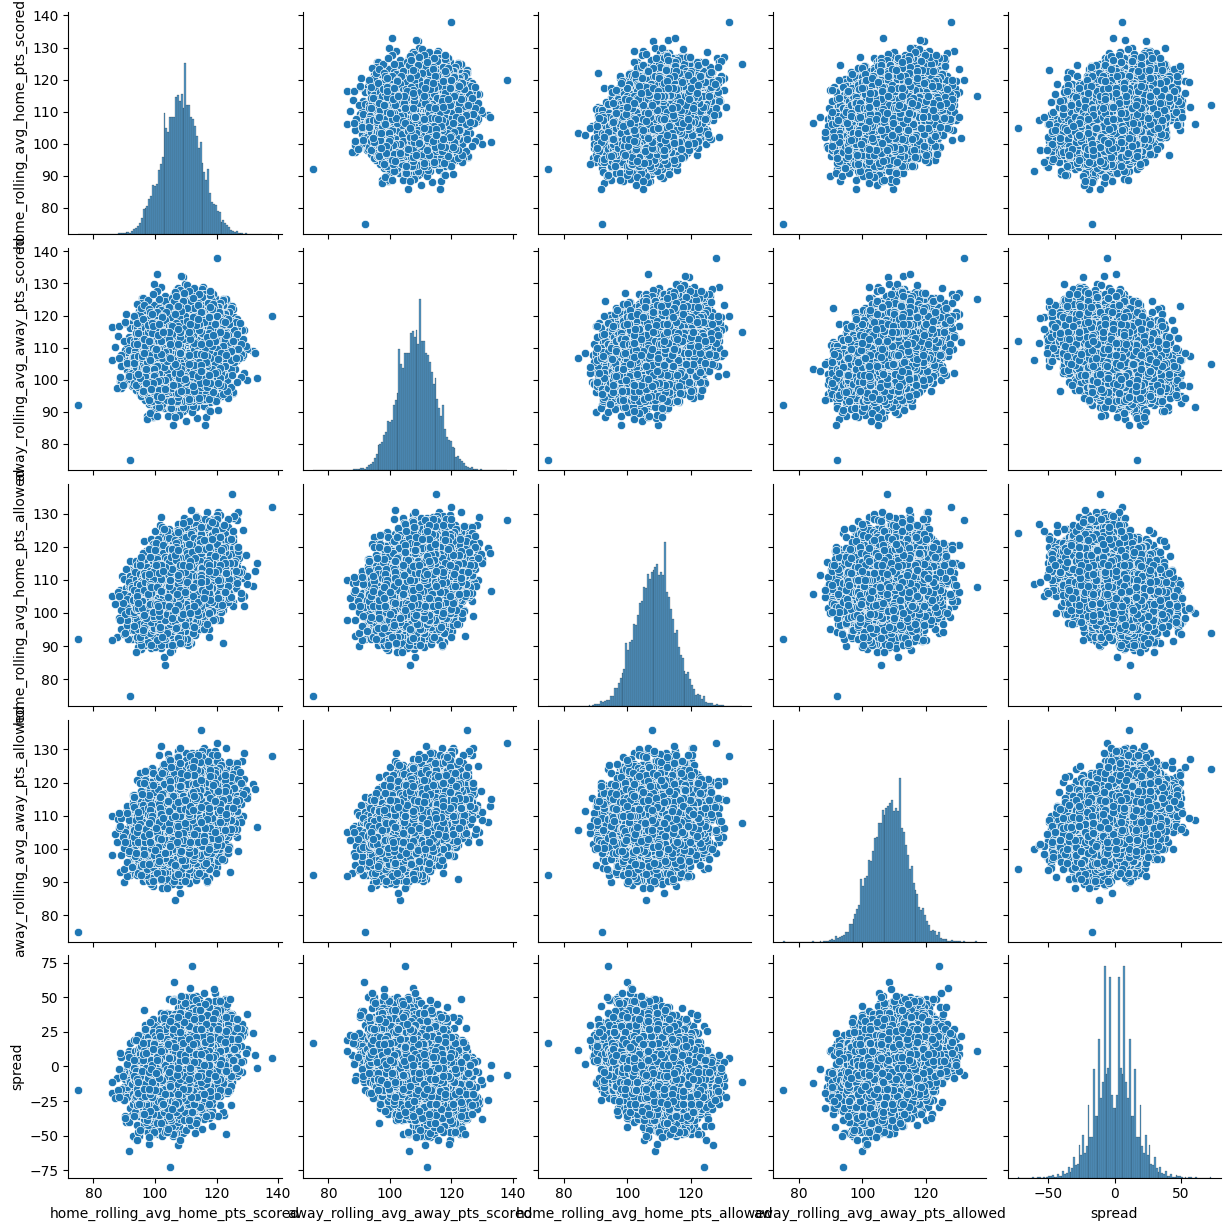

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting a subset of features and the target for pairplot
subset = data[['home_rolling_avg_home_pts_scored', 'away_rolling_avg_away_pts_scored', 'home_rolling_avg_home_pts_allowed', 'away_rolling_avg_away_pts_allowed', 'spread']]
sns.pairplot(subset)
plt.show()

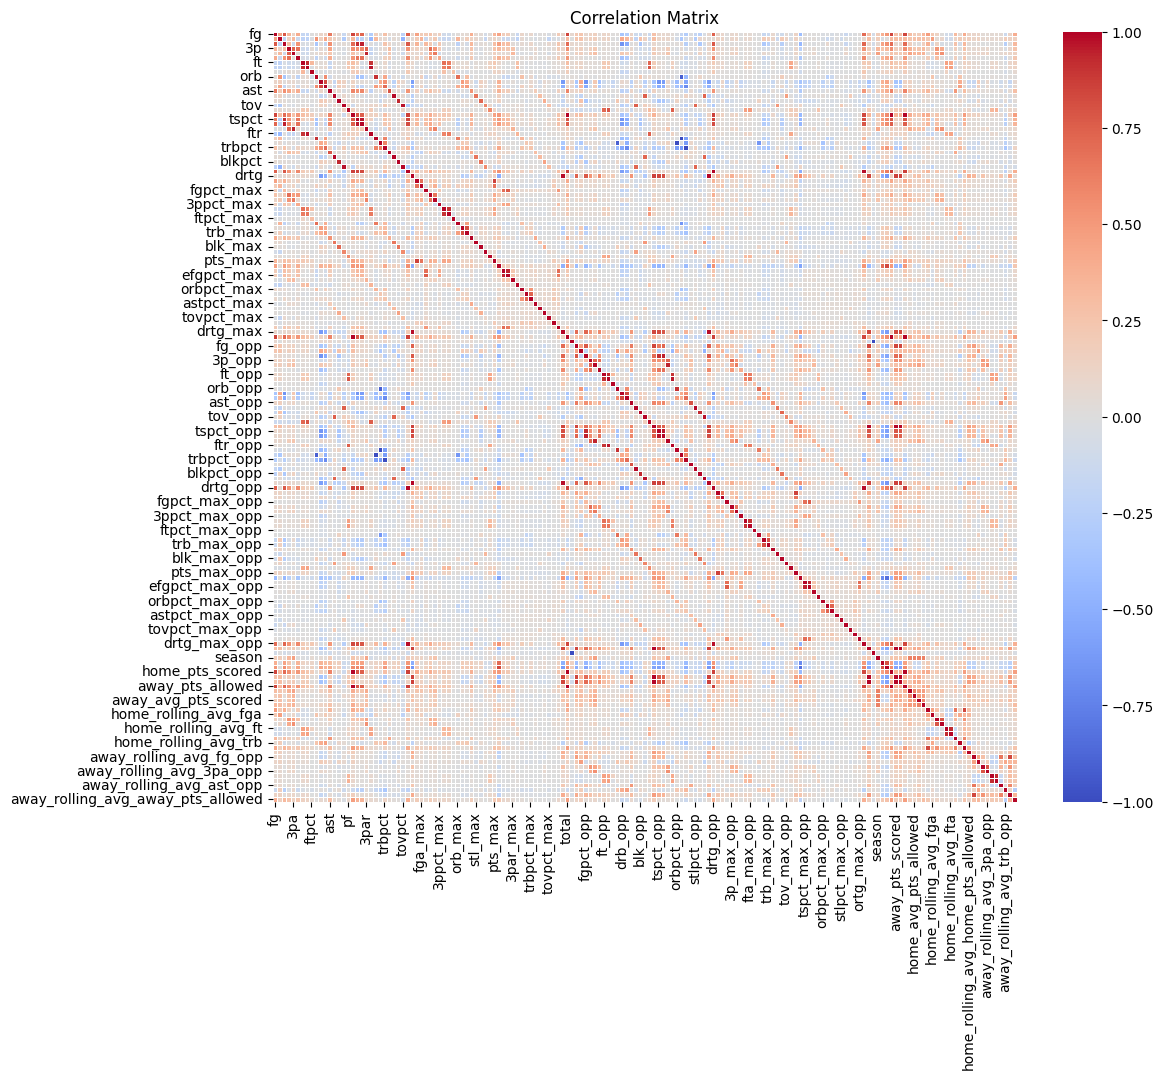

In [29]:
# Calculate correlation matrix
correlation_matrix = data.select_dtypes(include=[np.number]).corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

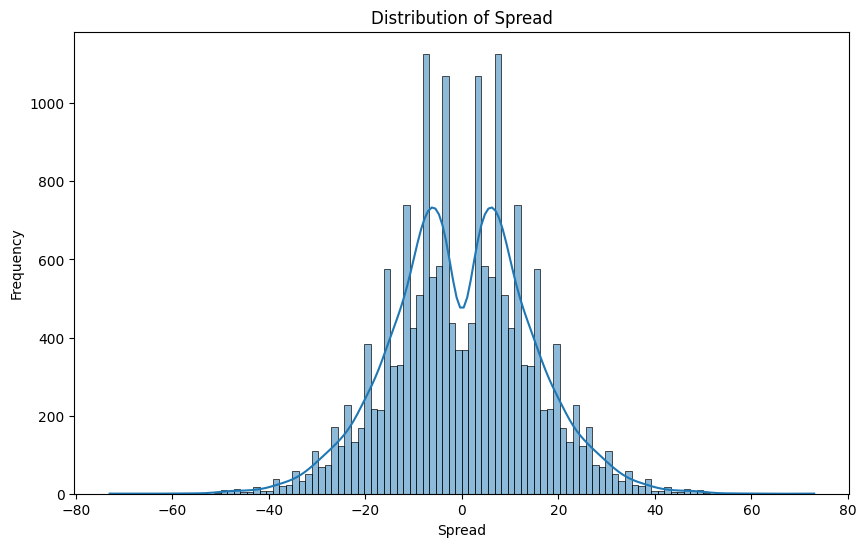

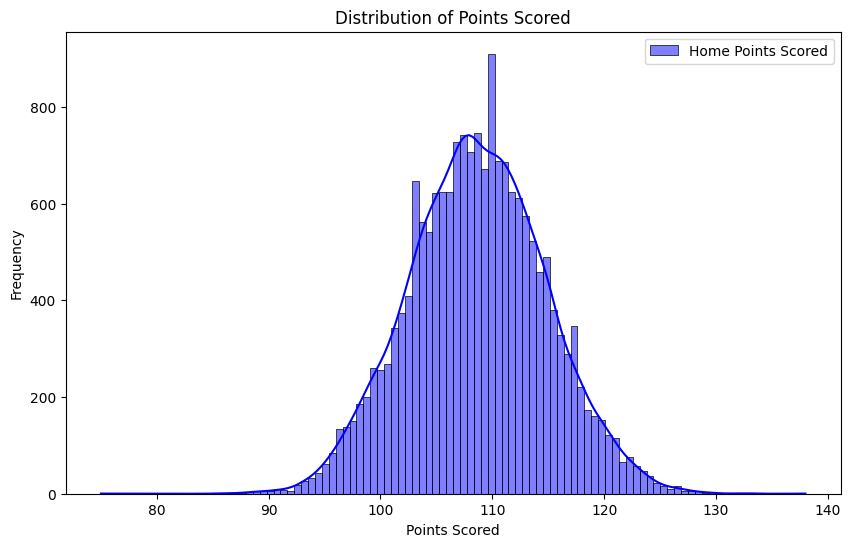

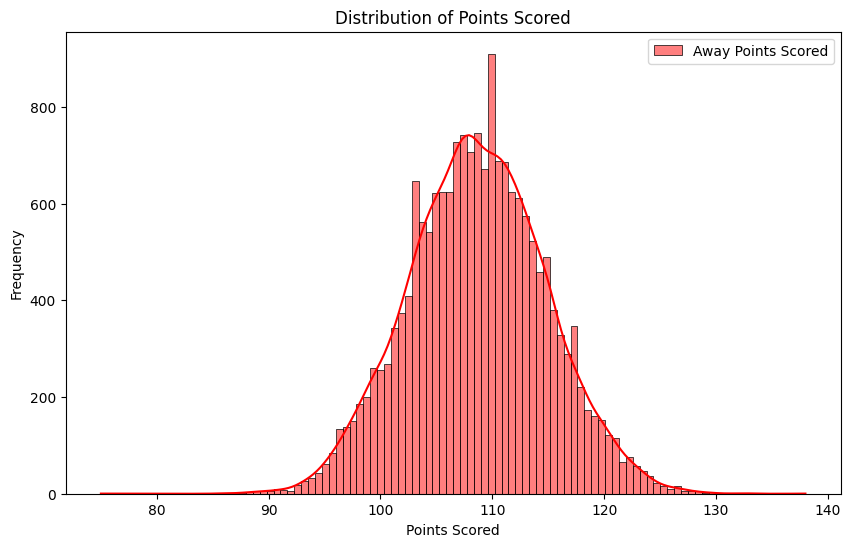

In [30]:
# Distribution of spread
plt.figure(figsize=(10, 6))
sns.histplot(data['spread'], kde=True)
plt.title('Distribution of Spread')
plt.xlabel('Spread')
plt.ylabel('Frequency')
plt.show()

# Distribution of points scored by home and away teams
plt.figure(figsize=(10, 6))
sns.histplot(data['home_rolling_avg_home_pts_scored'], kde=True, color='blue', label='Home Points Scored')
plt.title('Distribution of Points Scored')
plt.xlabel('Points Scored')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Distribution of points scored by home and away teams
plt.figure(figsize=(10, 6))
sns.histplot(data['away_rolling_avg_away_pts_scored'], kde=True, color='red', label='Away Points Scored')
plt.title('Distribution of Points Scored')
plt.xlabel('Points Scored')
plt.ylabel('Frequency')
plt.legend()
plt.show()


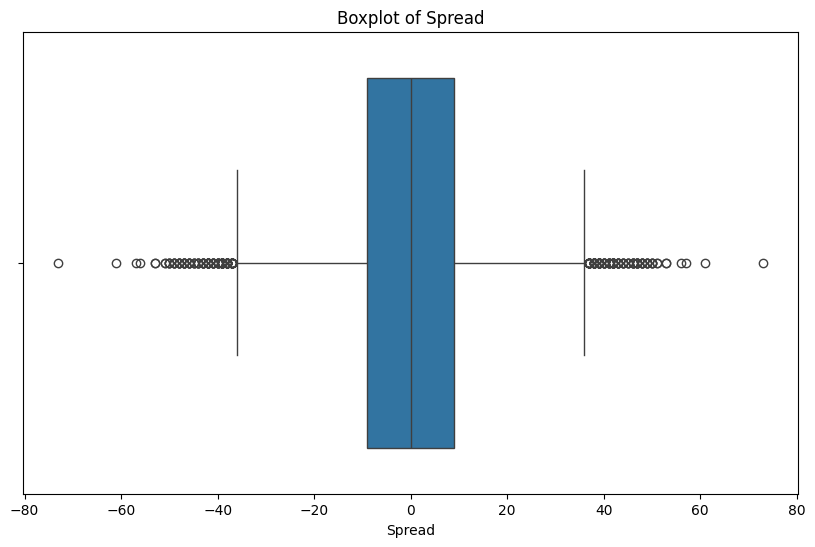

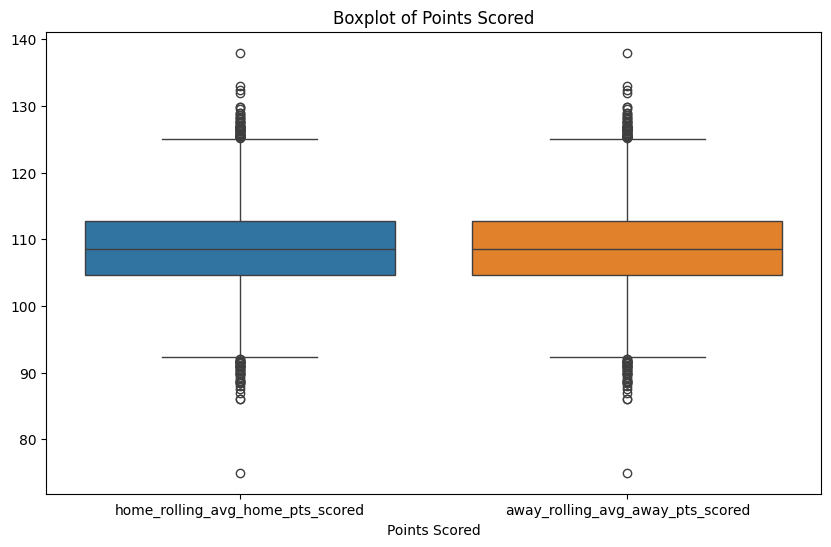

In [31]:
# Boxplot for spread
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['spread'])
plt.title('Boxplot of Spread')
plt.xlabel('Spread')
plt.show()

# Boxplot for points scored by home and away teams
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['home_rolling_avg_home_pts_scored', 'away_rolling_avg_away_pts_scored']])
plt.title('Boxplot of Points Scored')
plt.xlabel('Points Scored')
plt.show()


In [32]:
data.to_csv('../../app/result.csv', index=False)

# Making Predicitons Using Machine Learning

In [33]:
# Define the target variable
target = data['spread']

In [34]:
# Define the features - include team identifiers

# Define stats that will be unavailble when trying to make predictions on the future
unknown = ['total', 'total_opp', 'won', 'home_pts_scored', 'away_pts_scored', 'home_pts_allowed', 'away_pts_allowed']

features = data.drop(columns=['spread', 'date', 'season'] + unknown)

features[['team_opp', 'home_opp', 'home_team', 'away_team']]

,team_opp,home_opp,home_team,away_team
0,MIA,1,POR,MIA
1,POR,0,MIA,POR
2,DAL,1,CLE,DAL
3,CLE,0,DAL,CLE
4,DAL,1,ATL,DAL
...,...,...,...,...
18455,OKC,0,LAC,OKC
18456,ORL,1,LAC,ORL
18457,LAC,0,ORL,LAC
18458,MIA,1,BOS,MIA


In [35]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [36]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Identify numerical columns for scaling
numerical_columns = features.select_dtypes(include=['float64', 'int64']).columns

# Fit the scaler on the training data and transform both training and testing data
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [37]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
model = RandomForestRegressor()

# Train the model on the training data
model.fit(X_train[numerical_columns], y_train)

RandomForestRegressor()

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(y_true, y_pred):
    """
    Evaluate the model's predictions using various metrics and print the results.

    Parameters:
    y_true (array-like): True values.
    y_pred (array-like): Predicted values.

    Returns:
    dict: A dictionary with evaluation metrics.
    """
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)

    # Print evaluation results with explanations
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print("  - On average, the model's predictions are off by this many points.")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print("  - The average of the squared errors. Penalizes larger errors more than MAE.")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("  - The square root of MSE, providing error in the same unit as the target.")
    print(f"R-squared (R²): {r2:.4f}")
    print("  - Proportion of the variance in the target variable explained by the model. Closer to 1 is better.\n")

    # Return the results as a dictionary
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

# Example usage with model predictions
y_pred = model.predict(X_test[numerical_columns])
evaluation_results = evaluate_model(y_test, y_pred)

Mean Absolute Error (MAE): 1.6657
  - On average, the model's predictions are off by this many points.
Mean Squared Error (MSE): 5.4299
  - The average of the squared errors. Penalizes larger errors more than MAE.
Root Mean Squared Error (RMSE): 2.3302
  - The square root of MSE, providing error in the same unit as the target.
R-squared (R²): 0.9733
  - Proportion of the variance in the target variable explained by the model. Closer to 1 is better.



In [39]:
# from sklearn.model_selection import KFold

# # Prepare for K-Fold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# metrics = {'MAE': [], 'MSE': [], 'RMSE': [], 'R²': []}

# for train_index, test_index in kf.split(features):
#     X_train, X_test = features.iloc[train_index].copy(), features.iloc[test_index].copy()
#     y_train, y_test = target.iloc[train_index], target.iloc[test_index]

#     # Scale the numerical columns
#     X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
#     X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

#     # Train the model on the training data
#     model.fit(X_train[numerical_columns], y_train)

#     # Make predictions on the test data
#     y_pred = model.predict(X_test[numerical_columns])

#     # Evaluate the model's performance
#     fold_metrics = evaluate_model(y_test, y_pred)
#     for key, value in fold_metrics.items():
#         metrics[key].append(value)

# # Calculate average metrics across all folds
# average_metrics = {key: np.mean(value) for key, value in metrics.items()}
# print("\nAverage Metrics across all folds:")
# for key, value in average_metrics.items():
#     print(f"{key}: {value:.4f}")


# Making Predictions On Games

In [40]:
def get_recent_performance_stats(team, team_type, data):
    """
    Get the most recent performance statistics for a given team.

    Parameters:
    team (str): Team name.
    team_type (str): Type of the team ('home' or 'away').
    data (pd.DataFrame): The dataset.

    Returns:
    pd.Series: The most recent performance statistics for the team.
    """
    if team_type == 'home':
        team_data = data[data['home_team'] == team]
        
        team_data = team_data.select_dtypes(include=['float64', 'int64'])
        
        recent_stats = team_data.iloc[-1]
    
        recent_stats = recent_stats[[col for col in recent_stats.index if 'opp' not in col and 'away' not in col]]
        
        
    elif team_type == 'away':
        team_data = data[data['away_team'] == team]
        
        team_data = team_data.select_dtypes(include=['float64', 'int64'])
        
        recent_stats = team_data.iloc[-1]
    
        recent_stats = recent_stats[[col for col in recent_stats.index if 'opp' in col or 'away' in col]]
        
    else:
        raise ValueError("team_type must be 'home' or 'away'")
    
    if team_data.empty:
        raise ValueError(f"No recent performance stats found for team {team} as {team_type}.")
    
    return recent_stats

In [41]:
def prepare_features_for_prediction(home_team, away_team, data, scaler, numerical_columns):
    """
    Prepare the feature vector for prediction based on selected teams.
    
    Parameters:
    home_team (str): Home team name.
    away_team (str): Away team name.
    data (pd.DataFrame): The dataset.
    scaler (StandardScaler): The scaler used for training.
    numerical_columns (list): List of numerical columns used for scaling.
    
    Returns:
    np.ndarray: Scaled feature vector ready for prediction.
    """
    try:
        home_stats = get_recent_performance_stats(home_team, 'home', data)
        away_stats = get_recent_performance_stats(away_team, 'away', data)
    except ValueError as e:
        print(f"Error in getting recent performance stats: {e}")
        return None
    
    # Concatenate the stats
    feature_vector = pd.concat([home_stats, away_stats]).to_frame().T

    feature_vector = feature_vector[numerical_columns]
    
    # Scale the feature vector
    feature_vector_scaled = scaler.transform(feature_vector)
    
    return feature_vector_scaled

In [42]:
# Example usage
home_team = 'BOS'  # User-selected home team
away_team = 'LAL'  # User-selected away team

# Prepare features for the selected teams
feature_vector = prepare_features_for_prediction(home_team, away_team, features, scaler, numerical_columns)

# Make a prediction using the trained model
predicted_spread = model.predict(feature_vector)
print(f"Predicted spread: {predicted_spread[0]}")

Predicted spread: -6.26


/Users/NoahWright/Desktop/CS Stuff/ML/NBA/nba_env/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [43]:
joblib.dump(model, '../../app/predict_model.pkl')
joblib.dump(scaler, '../../app/model_scaler.pkl')

['../../app/model_scaler.pkl']